# Solve Helmholtz equation 
$ (1-\lambda \nabla^2)u = f $


In [3]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../") # go to parent directory

from pypde import *
import numpy as np
import matplotlib.pyplot as plt

N,M = 30,20
shape = (N,M)

dt = 0.1
kappa = 1.0
lam = dt*kappa


# Helmholtz test
LAM = 1/np.pi**6 

def _f(xx,yy,lam=LAM):
    return  (1.0+2*lam*np.pi**2/4)*_u(xx,yy)

def _u(xx,yy):
    return np.cos(np.pi/2*xx)*np.cos(np.pi/2*yy)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup Field

In [20]:
u = Field(shape,("CD","CD"))
x,y = u.x, u.y
xx,yy = np.meshgrid(x,y,indexing="ij")

## Matrices

In [21]:
from pypde.bases import *
lam = LAM
# --- Matrices ----
Sx = u.xs[0].S
Bx = u.xs[0].family.B(2,2)
Ix = u.xs[0].family.I(2)
Ax =  Bx@Sx-lam*Ix@Sx

Sy = u.xs[1].S
By = u.xs[1].family.B(2,2)
Iy = u.xs[1].family.I(2)
Ay =  By@Sy-lam*Iy@Sy

#plt.spy(Ay)
#plt.show()

## Plans

In [22]:
# Add them
solver = SolverPlan()
solver.add_rhs(PlanRHS(Bx,ndim=2,axis=0))
solver.add_rhs(PlanRHS(By,ndim=2,axis=1))

solver.add_lhs( PlanLHS(Ax,ndim=2,axis=0,method="fdma") )
solver.add_lhs( PlanLHS(Ay,ndim=2,axis=1,method="fdma") )

solver.show_plan()

Plans RHS:
1 ) Apply method 'multiply' along axis 0 
2 ) Apply method 'multiply' along axis 1 

Plans LHS:
1 ) Apply method 'fdma' along axis 0 
2 ) Apply method 'fdma' along axis 1 



## Solve


In [23]:
f = Field(shape,("CH","CH"))
f.v = _f(xx,yy)
f.forward()

def iterate(rhs):
    # Solve them
    rhs = solver.solve_rhs(rhs)
    u.vhat = solver.solve_lhs(rhs)
    
iterate(f.vhat)

## Compare

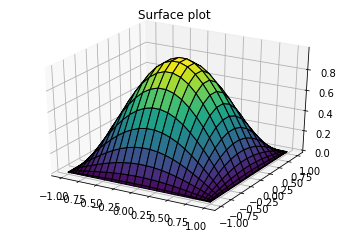

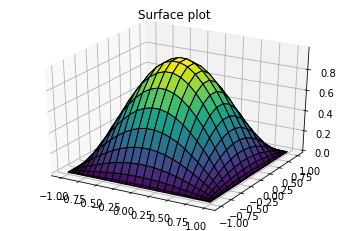

|err|: 1.02e-02


In [24]:
u.backward()
plot(xx,yy,u.v)
plot(xx,yy,_u(xx,yy))
norm = np.linalg.norm(u.v-_u(xx,yy))
print("|err|: {:5.2e}"
            .format(norm))